# Chronic Lymphotic Leukemia dataset

Pacienti s chronickou leukémiou chodia na pravidelné vyšetrenie, bežne raz za mesiac. Choroba sa lieči ale sa nevylieči. Keď je stav zlepšený, tak môžu chodiť v intervale 3 alebo 6 mesiacov. Laboratórne vyšetrenie sa robí odberom, potom testy v laboratoriách, hodnoty sa sumarizujú a posielajú naspäť lekárom. Každé takéto vyšetrenie má rozsiahle výsledky, ktoré sa hodnotia dlho. Nemocnica vedie aj centrálne záznamy o pacientoch (osobné údaje), kontakty s poisťovňou aj ďalšie potrebné údaje.

V záznamoch laboratórnych vyšetrení je závislá premenná (**indikator**) indikujúca stavu choroby pacienta. Ide o indikáciu či patient potrebuje ďalšie laboratórne vyšetrenie v preddefinovanom intervale alebo ten interval sa dá predĺžiť na základe výsledkov laboratorných testov aj osobných údajov pacienta.

Pokiaľ má indikátor nenulovú hodnotu, pacientov stav nie je zlepšený a je nutné ďalšie laboratórne vyšetrenie.

V dátach sú údaje 3060 ľudí. **SSN - social security number** je ich unique ID.



| atribút     | poznámka                                           |
|-------------|----------------------------------------------------|
| hemoglobin  | farbivo červených krviniek                         |
| hematocrit  | percentuálne zastúpenie červených krviniek v krvi  |
| leukocytes  | biele krvinky                                      |
| erytrocytes | červené krvinky                                    |
| trombocytes | krvné doštičky                                     |
| alt         | alanine aminotransferase enzým                     |
| alp         | alkaline phosphatase enzým                         |
| ast         | aspartate aminotransferase enzým                   |
| er-cv       |                                                    |
| etytr       |                                                    |
| hbver       |                                                    |



In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import pylab as py
import scipy.stats as stats
import category_encoders as ce

from numpy.random import randn
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.svm import LinearSVC, SVR
from sklearn.feature_selection import RFE
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

## Príprava dát

In [2]:
filename = "data/labor.csv"
labor = pd.read_csv(filename, sep='\t', index_col=0)

filename = "data/profiles.csv"
profiles = pd.read_csv(filename, sep='\t', index_col=0, parse_dates=['birthdate'])

**Tabuľka *labor***
- zmena hodnoty *smoker* z 'N' na 'no' z 'Y' na 'yes'
- premenovanie názvov stĺpcov
- odstraňovanie duplikátov
- úprava null hodnôt pomocou vymazania alebo kNN klasifikácie

In [3]:
labor['smoker'] = np.where(labor['smoker'] == 'N', 'no', labor['smoker'])
labor['smoker'] = np.where(labor['smoker'] == 'Y', 'yes', labor['smoker'])

In [4]:
labor.rename(columns = {'hematokrit':'hematocrit', 'leukocyty':'leukocytes', 'erytrocyty':'erytrocytes', 'trombocyty':'trombocytes'}, inplace = True)

In [5]:
labor.drop_duplicates(inplace=True)

In [6]:
labor.isnull().sum()

name             0
hematocrit      30
smoker           0
leukocytes      30
relationship     0
ssn              0
alt             30
weight           0
erytrocytes     30
alp             30
ast             30
er-cv           30
etytr           30
hemoglobin      30
trombocytes     30
indicator        0
hbver           30
dtype: int64

V tomto prípade použijeme náhodné rozhodovanie o tom, či zmažeme riadky s null hodnotami alebo nie pretože všetky atribúty majú rovnaký počet týchto hodnôt. V lepšom scenári by sme mohli rozhodovať napríklad podľa počtu null hodnôt - ak by presahovali viac ako 1% veľkosti datasetu, dopĺňali by sme ich.

In [7]:
attr = set(labor.columns)
before = labor.shape[0]

for a in attr:
    if labor[a].isnull().sum() > 0:
        if random.randint(0,100) < 60:
            labor.dropna(subset=[a], inplace=True)

print("Odstránených bolo %d riadkov" % (before - labor.shape[0]))

Odstránených bolo 234 riadkov


Resetovanie indexu po vymazávaní outlierov a dopĺňanie nezmazaných riadkov obsahujúcich NaN hodnoty pomocou kNN imputer. Atribúty *ssn* a *smoker* (nenumerické atribúty) do kNN nevstupujú a z datasetu sa pred spustením kNN odpoja.

In [8]:
labor = labor.reset_index()
labor.drop('index', axis=1, inplace=True)

In [9]:
ssn = labor['ssn']
smoker = labor['smoker']

In [10]:
cols = labor.columns
index = cols.get_loc("indicator")

y = labor.indicator
colnames_numerics_only = labor.select_dtypes(include=np.number).columns.tolist()
X = labor[colnames_numerics_only]
X = X.drop('indicator', axis=1)

print('Replacing %d values' % np.isnan(X).sum().sum())

imputer = KNNImputer()
labor = pd.DataFrame(imputer.fit_transform(X),columns = X.columns)

labor.insert(loc=0, column='indicator', value=y)


print('NaN values left: %d' % np.isnan(labor).sum().sum())

labor.insert(loc=1, column='ssn', value=ssn)
labor.insert(loc=1, column='smoker', value=smoker)

Replacing 89 values
NaN values left: 0


In [11]:
labor.isnull().sum()

indicator      0
smoker         0
ssn            0
hematocrit     0
leukocytes     0
alt            0
weight         0
erytrocytes    0
alp            0
ast            0
er-cv          0
etytr          0
hemoglobin     0
trombocytes    0
hbver          0
dtype: int64

**Spojenie tabuliek**

Na uľahčenie práce s dátami vytvoríme jednu tabuľku - *data*, ktorá je spojená podľa unikátneho identifikátora *ssn*.

Sú v nej zahrnuté iba relevantné atribúty, ktoré sa v predchádzajúcej fáze osvedčili ako informatívne.

In [12]:
data = labor.merge(profiles, how='left', on='ssn')

include = set(data.columns) - {'birthdate', 'company', 'job', 'name_x', 'name_y', 'address', 'ssn', 'race', 'relationship', 'weight', 'name'}
data = data[list(include)]
data.head(2)

,etytr,trombocytes,sex,hematocrit,indicator,erytrocytes,hbver,smoker,leukocytes,blood_group,alp,alt,er-cv,ast,hemoglobin
0,6.93084,2.43339,F,5.10789,0.0,7.92270,6.73439,no,3.67594,AB+,80.65839,1.36076,46.67907,40.27331,7.07385
1,6.17378,3.16922,M,6.06717,0.0,7.13748,6.69188,no,6.61722,A-,95.49950,1.10335,21.09764,51.14865,6.30636


____
## Integrácia a čistenie dát
### Kódovanie dát na číselné hodnoty

- *smoker* - hodnota 'no' na 0 a 'yes' na 1
- *sex* - hodnota 'M' na 0 a 'F' na 1
- *blood_group* namapovaný ako 0+, A-, 0-, B+, B-, A+, AB+, AB- = 1, 2, 3, 4, 5, 6, 7, 8


Všetky tieto hodnoty sú nominálne - jednotlivé vlastnosti spolu nesúvisia, a tak je treba použiť OneHotEncoder. Nakoľko však vytvára nové stĺpce, nie je vhodnou voľbou pre kódovanie rozsiahleho *blood_group* atribútu.

In [13]:
ohe = ce.OneHotEncoder(cols=['smoker'])
data = ohe.fit_transform(data)
data.rename(columns = {'smoker_1':'smoker_no', 'smoker_2':'smoker_yes'}, inplace = True)

ohe = ce.OneHotEncoder(cols=['sex'])
data = ohe.fit_transform(data)
data.rename(columns = {'sex_1':'male', 'sex_2':'female'},  inplace = True)

In [14]:
ce_ordinal_blood = ce.OrdinalEncoder(cols=['blood_group'])
data = ce_ordinal_blood.fit_transform(data)

In [15]:
data.head(4)

,etytr,trombocytes,male,female,hematocrit,indicator,erytrocytes,hbver,smoker_no,smoker_yes,leukocytes,blood_group,alp,alt,er-cv,ast,hemoglobin
0,6.93084,2.43339,1,0,5.10789,0.0,7.92270,6.73439,1,0,3.67594,1,80.65839,1.36076,46.67907,40.27331,7.07385
1,6.17378,3.16922,0,1,6.06717,0.0,7.13748,6.69188,1,0,6.61722,2,95.49950,1.10335,21.09764,51.14865,6.30636
2,7.25101,5.54453,1,0,8.52161,0.0,9.11128,6.08754,0,1,8.76540,3,57.21363,3.08378,67.05110,57.61393,7.74219
3,6.18335,5.34519,0,1,4.35962,0.0,9.68805,6.34100,1,0,6.61320,2,82.12788,5.08135,53.04260,75.41991,5.69975


____
### Outlier detection


Na identifikovanie a upravovanie outlierov použijeme interquartile range metódu. Pokiaľ je počet outlierov nižší ako 1% datasetu, zmažú sa. V opačnom prípade sa ich hodnoty upravujú.

In [16]:
def identify_outliers(a):
    lower = a.quantile(0.25) - 1.5 * stats.iqr(a)
    upper = a.quantile(0.75) + 1.5 * stats.iqr(a)
    
    return a[(a > upper) | (a < lower)]

In [17]:
def delete_or_keep_outliers(n):
    if n < len(data) * 0.01:
        print("Delete outliers")
    else:
        print("Keep outliers")

In [18]:
def change_outliers(a):
    lower = data[a].quantile(0.25) - 1.5 * stats.iqr(data[a])
    upper = data[a].quantile(0.75) + 1.5 * stats.iqr(data[a])
        
    return np.where(data[a] > upper, upper, np.where(data[a] < lower, lower, data[a]))

**Alp**

In [19]:
out = identify_outliers(data.alp)
print('Identified outliers: %d' % len(out))
delete_or_keep_outliers(len(out))

Identified outliers: 472
Keep outliers


In [20]:
data['alp'] = change_outliers('alp')

**Alt**

In [21]:
out = identify_outliers(data.alt)
print('Identified outliers: %d' % len(out))
delete_or_keep_outliers(len(out))

Identified outliers: 982
Keep outliers


In [22]:
data['alt'] = change_outliers('alt')

**Ast**

In [23]:
out = identify_outliers(data.ast)
print('Identified outliers: %d' % len(out))
delete_or_keep_outliers(len(out))

Identified outliers: 77
Delete outliers


In [24]:
data = data.drop(out.index)

**Etytr**

In [25]:
out = identify_outliers(data.etytr)
print('Identified outliers: %d' % len(out))
delete_or_keep_outliers(len(out))

Identified outliers: 69
Delete outliers


In [26]:
data = data.drop(out.index)

**Er-cv**

In [27]:
out = identify_outliers(data['er-cv'])
print('Identified outliers: %d' % len(out))
delete_or_keep_outliers(len(out))

Identified outliers: 80
Delete outliers


In [28]:
data = data.drop(out.index)

**Erytrocytes**

In [29]:
out = identify_outliers(data.erytrocytes)
print('Identified outliers: %d' % len(out))
delete_or_keep_outliers(len(out))

Identified outliers: 12
Delete outliers


In [30]:
data = data.drop(out.index)

**Hbver**

In [31]:
out = identify_outliers(data.hbver)
print('Identified outliers: %d' % len(out))
delete_or_keep_outliers(len(out))

Identified outliers: 81
Delete outliers


In [32]:
data = data.drop(out.index)

**Hematocrit**

In [33]:
out = identify_outliers(data.hematocrit)
print('Identified outliers: %d' % len(out))
delete_or_keep_outliers(len(out))

Identified outliers: 15
Delete outliers


In [34]:
data = data.drop(out.index)

**Hemoglobin**

In [35]:
out = identify_outliers(data.hemoglobin)
print('Identified outliers: %d' % len(out))
delete_or_keep_outliers(len(out))

Identified outliers: 73
Delete outliers


In [36]:
data = data.drop(out.index)

**Leukocytes**

In [37]:
out = identify_outliers(data.leukocytes)
print('Identified outliers: %d' % len(out))
delete_or_keep_outliers(len(out))

Identified outliers: 6
Delete outliers


In [38]:
data = data.drop(out.index)

**Trombocytes**

In [39]:
out = identify_outliers(data.trombocytes)
print('Identified outliers: %d' % len(out))
delete_or_keep_outliers(len(out))

Identified outliers: 48
Delete outliers


In [40]:
data = data.drop(out.index)

Zresetovanie indexov po všetkých mazaniach hodnôt.

In [41]:
data = data.reset_index()
data.drop('index', axis=1, inplace=True)

data.shape

(9245, 17)

Skopírovanie dataframe pre posledný bod pre zachovanie dát

In [42]:
dataforPipe = data.copy(deep=True)

## Realizácia predspracovania dát 

### Rozdelenie na trénovaciu a testovaciu množinu
Rozdelenie v pomere 80:20

In [44]:
y = data.indicator
X = data.drop('indicator', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7396, 16) (1849, 16) (7396,) (1849,)


In [45]:
data = X_train

In [46]:
data.describe()

,etytr,trombocytes,male,female,hematocrit,erytrocytes,hbver,smoker_no,smoker_yes,leukocytes,blood_group,alp,alt,er-cv,ast,hemoglobin
count,7396.000000,7396.000000,7396.000000,7396.000000,7396.000000,7396.000000,7396.000000,7396.000000,7396.000000,7396.000000,7396.000000,7396.000000,7396.000000,7396.000000,7396.000000,7396.000000
mean,6.473264,6.853303,0.500676,0.499324,6.449351,6.904693,6.473023,0.607220,0.392780,6.441194,4.462277,72.772618,1.043470,49.243409,52.189304,6.463055
std,0.967201,1.700994,0.500033,0.500033,1.654031,1.595154,0.956219,0.488402,0.488402,1.690212,2.286997,16.405081,0.711056,12.749150,11.495062,0.973403
min,3.793790,2.053750,0.000000,0.000000,1.760910,2.335850,3.811080,0.000000,0.000000,1.734990,1.000000,32.088417,0.026580,14.477540,20.880870,3.773490
25%,5.794548,5.684860,0.000000,0.000000,5.197680,5.756907,5.824005,0.000000,0.000000,5.173930,2.000000,64.390518,0.523510,40.563688,44.454560,5.802087
50%,6.473235,7.008090,1.000000,0.000000,6.222725,7.036800,6.480965,1.000000,0.000000,6.339970,4.000000,78.400945,0.777580,49.099245,52.188470,6.474755
75%,7.141743,8.084315,1.000000,1.000000,7.682100,8.042610,7.129435,1.000000,1.000000,7.690295,6.000000,84.989178,1.346920,58.036563,59.933165,7.129347
max,9.159010,11.689190,1.000000,1.000000,11.303560,11.440480,9.132920,1.000000,1.000000,11.291590,8.000000,100.000000,2.578226,83.734840,83.807330,9.155650


In [47]:
data

,etytr,trombocytes,male,female,hematocrit,erytrocytes,hbver,smoker_no,smoker_yes,leukocytes,blood_group,alp,alt,er-cv,ast,hemoglobin
1430,6.24886,5.14203,0,1,7.33993,7.05230,5.37446,0,1,7.43566,5,83.81437,0.720670,32.51206,45.39593,6.73877
7064,6.43111,9.15557,1,0,4.90794,6.33497,5.27428,1,0,8.36542,3,91.31883,0.734210,42.93840,63.26918,6.14065
3562,7.96093,6.06634,1,0,6.25975,7.23869,4.09109,1,0,6.31522,6,65.36749,0.949230,49.06949,48.07503,7.55247
4571,5.80256,8.44888,0,1,5.48512,6.93782,6.75140,0,1,7.83282,4,87.60307,0.766670,49.05363,64.31866,6.48718
4841,6.45923,8.67833,0,1,5.14435,6.76051,7.97638,1,0,6.51035,8,78.25868,0.593170,42.46957,32.19306,6.90486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3223,8.23323,6.13515,0,1,7.89925,3.89017,6.24591,1,0,4.71356,1,65.12951,0.331130,48.59240,29.93851,5.06503
4508,5.67050,7.73980,1,0,6.40675,7.32201,6.07581,1,0,9.36916,4,60.98947,0.659140,54.62581,54.09285,7.52976
4345,7.77943,6.43281,0,1,9.18692,9.57747,6.56991,0,1,9.39014,7,77.23971,2.578226,57.19043,48.55181,6.94242
4219,5.99502,4.30390,0,1,7.19238,8.12273,7.03904,1,0,7.49033,8,84.37856,1.358380,69.20114,49.92092,6.65194


### Škálovanie a normalizácia dát

array([[<AxesSubplot:title={'center':'etytr'}>,
        <AxesSubplot:title={'center':'trombocytes'}>,
        <AxesSubplot:title={'center':'hematocrit'}>],
       [<AxesSubplot:title={'center':'hbver'}>,
        <AxesSubplot:title={'center':'erytrocytes'}>,
        <AxesSubplot:title={'center':'leukocytes'}>],
       [<AxesSubplot:title={'center':'blood_group'}>,
        <AxesSubplot:title={'center':'alp'}>,
        <AxesSubplot:title={'center':'alt'}>],
       [<AxesSubplot:title={'center':'er-cv'}>,
        <AxesSubplot:title={'center':'ast'}>,
        <AxesSubplot:title={'center':'hemoglobin'}>]], dtype=object)

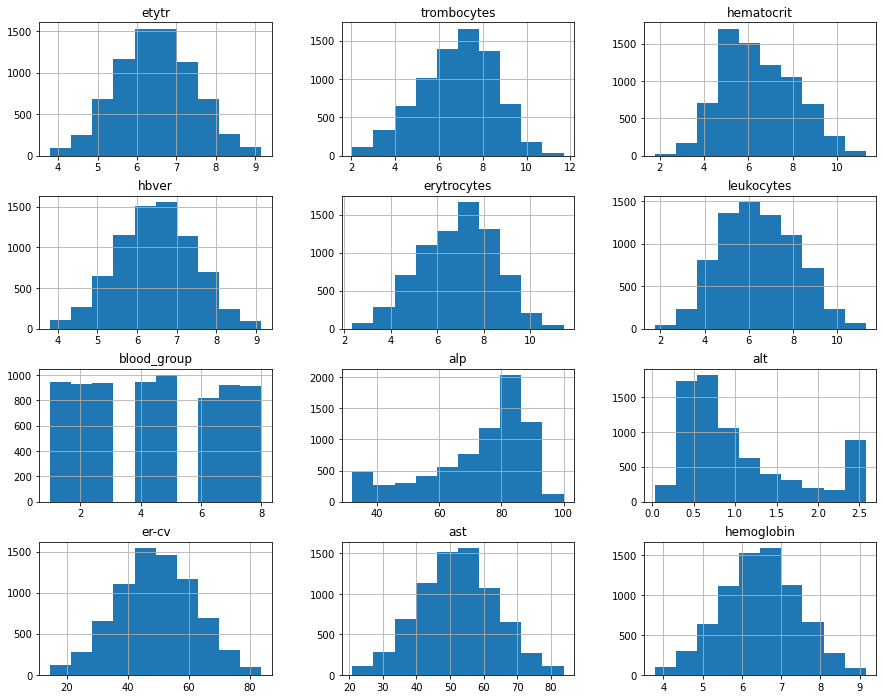

In [48]:
attr = set(data.columns) - {'smoker_no', 'smoker_yes', 'male', 'female', 'indicator'}
attr = list(attr)

data[attr].hist(figsize=(15,12))

**Yeo-Johnson** na vyhladenie atribútov podľa gaussovho rozdelenia. Niektoré hodnoty ako *alt*, *hematocrit* a *alp* potrebujú upraviť kvôli príliš odchýlenej skewness.

In [49]:
print("alt = %s\t hematocrit = %s\t alp = %s" % (data.alt.skew(), data.hematocrit.skew(), data.alp.skew()))

alt = 1.0936420303662153	 hematocrit = 0.29750175776313664	 alp = -1.043429157665256


In [51]:
pow_attr = attr.copy()
pow_attr.remove('blood_group')

for a in pow_attr:
    transformer = PowerTransformer(method='yeo-johnson',  standardize=False)
    column = data[a].values
    column = column.reshape((len(column),1))
    col_trans = transformer.fit_transform(column)
    data = data.drop(a, axis=1)
    data.insert(loc=0, column=a, value=col_trans) 

In [54]:
print("alt = %s\t hematocrit = %s\t alp = %s" % (data.alt.skew(), data.hematocrit.skew(), data.alp.skew()))

alt = 0.13115110323368193	 hematocrit = -0.012248978719075035	 alp = -0.3479703187420437


**MinMax Scaler** na škálovanie hodnôt od 0 po 1 aby boli všetky hodnoty v rovnakom rozsahu.

In [56]:
for a in attr:
    scaler = MinMaxScaler()
    column = data[a].values
    column = column.reshape((len(column),1))
    col_trans = scaler.fit_transform(column)
    data = data.drop(a, axis=1)
    data.insert(loc=0, column=a, value=col_trans) 

array([[<AxesSubplot:title={'center':'etytr'}>,
        <AxesSubplot:title={'center':'trombocytes'}>,
        <AxesSubplot:title={'center':'hematocrit'}>],
       [<AxesSubplot:title={'center':'hbver'}>,
        <AxesSubplot:title={'center':'erytrocytes'}>,
        <AxesSubplot:title={'center':'leukocytes'}>],
       [<AxesSubplot:title={'center':'blood_group'}>,
        <AxesSubplot:title={'center':'alp'}>,
        <AxesSubplot:title={'center':'alt'}>],
       [<AxesSubplot:title={'center':'er-cv'}>,
        <AxesSubplot:title={'center':'ast'}>,
        <AxesSubplot:title={'center':'hemoglobin'}>]], dtype=object)

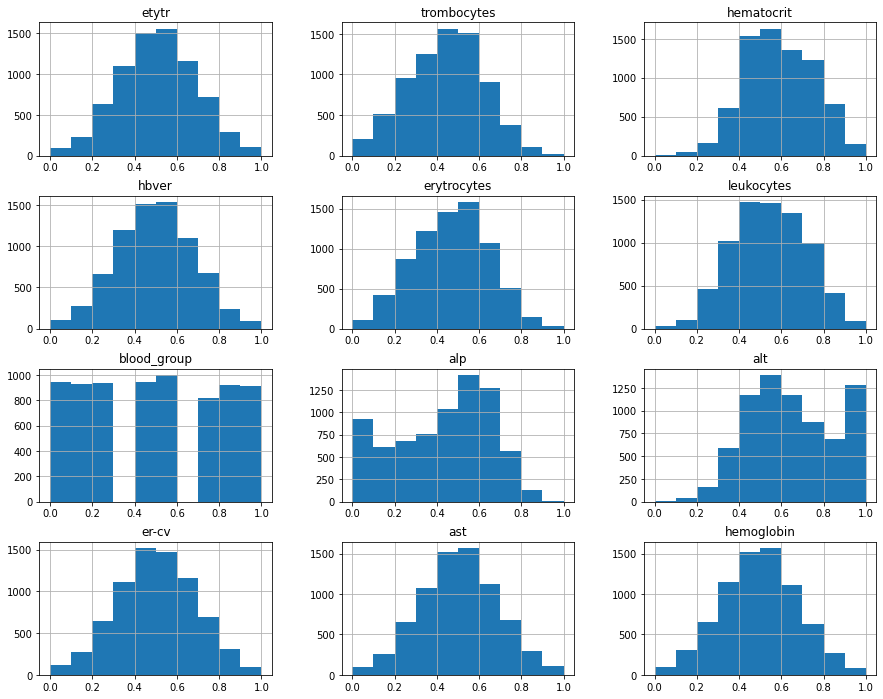

In [57]:
data[attr].hist(figsize=(15,12))

In [58]:
data.describe()

,hemoglobin,ast,er-cv,alt,alp,blood_group,leukocytes,erytrocytes,hbver,hematocrit,trombocytes,etytr,male,female,smoker_no,smoker_yes
count,7396.000000,7396.000000,7396.000000,7396.000000,7396.000000,7396.000000,7396.000000,7396.000000,7396.000000,7396.000000,7396.000000,7396.000000,7396.000000,7396.000000,7396.000000,7396.000000
mean,0.495974,0.505364,0.503601,0.651014,0.427853,0.494611,0.543197,0.468271,0.496059,0.589583,0.442031,0.508338,0.500676,0.499324,0.607220,0.392780
std,0.180959,0.182225,0.183970,0.210710,0.228276,0.326714,0.172268,0.176034,0.179790,0.161259,0.176504,0.179927,0.500033,0.500033,0.488402,0.488402
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.372751,0.383519,0.378519,0.491058,0.250834,0.142857,0.417337,0.338512,0.373652,0.472204,0.314726,0.382824,0.000000,0.000000,0.000000,0.000000
50%,0.497595,0.506494,0.501757,0.626560,0.473618,0.428571,0.539423,0.478401,0.496949,0.578655,0.450515,0.509637,1.000000,0.000000,1.000000,0.000000
75%,0.619589,0.628624,0.630576,0.814089,0.608813,0.714286,0.673096,0.592386,0.619208,0.714917,0.567818,0.633299,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


____

## Výber atribútov pre strojové učenie

In [60]:
data.head(2)

,hemoglobin,ast,er-cv,alt,alp,blood_group,leukocytes,erytrocytes,hbver,hematocrit,trombocytes,etytr,male,female,smoker_no,smoker_yes
1430,0.546741,0.398547,0.262040,0.600083,0.583167,0.571429,0.648442,0.480132,0.289635,0.684346,0.261935,0.467860,0,1,0,1
7064,0.435518,0.680953,0.412828,0.606559,0.759035,0.285714,0.737344,0.400938,0.270953,0.440127,0.690207,0.501805,1,0,1,0


**Mutual Information, Chi-Squared a F-value**

Zoradenie atribútov od najviac relevantných podľa Chi-Squared funkcie.

In [61]:
y = y_train
X = data

feature_count = X.shape[1]

bestfeatures = SelectKBest(score_func=chi2, k=feature_count)
fit = bestfeatures.fit(X,y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Attribute','Score']

print(featureScores.nlargest(feature_count,'Score'))

      Attribute       Score
10  trombocytes  205.936460
7   erytrocytes   50.740219
3           alt   37.426936
5   blood_group    0.776192
0    hemoglobin    0.224254
9    hematocrit    0.116435
8         hbver    0.071879
11        etytr    0.070326
2         er-cv    0.026560
1           ast    0.025198
4           alp    0.016192
6    leukocytes    0.010689
15   smoker_yes    0.004545
13       female    0.003528
12         male    0.003518
14    smoker_no    0.002940


**L1-based feature selection**

Pri tejto metóde sa osvedčila citlivosť 0.01, ktorá nám vybrala 5 relevantných atribútov.

In [62]:
y = y_train
X = data

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
selector = SelectFromModel(estimator=lsvc, prefit=True)
X_new = selector.transform(X)

selected_feat = X.columns[(selector.get_support())]
print('Total features: {}'.format((X.shape[1])))
print('Selected features: {}'.format(len(selected_feat)))
print(selected_feat)

Total features: 16
Selected features: 5
Index(['blood_group', 'leukocytes', 'erytrocytes', 'hematocrit',
       'trombocytes'],
      dtype='object')


**Recursive feature elimination**

Pri tejto metóde nastavíme premennú *features_to_select* na 5 aby sme mali rovnaký počet atribútov ako pri L1.

In [63]:
y = y_train
X = data

estimator = SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(X, y)

print(selector.support_)
print(selector.ranking_)

[False False False  True False False  True  True False  True  True False
 False False False False]
[ 3  2  5  1  6  4  1  1  7  1  1  8 12 10 11  9]


In [64]:
attrs_to_keep = list(selected_feat)
for (a, b) in zip(data.columns, selector.support_):
    if b==True and a not in attrs_to_keep:
        attrs_to_keep.append(a)
        
attrs_to_keep

['blood_group',
 'leukocytes',
 'erytrocytes',
 'hematocrit',
 'trombocytes',
 'alt']

Zjednotili sme vybrané atribúty z L1 a recursive feature elimination. V tomto prípade nám vyšlo 6 relevantných atribútov.

____
## Replikovateľnosť predspracovania

Úprava kódu pomocou funkcií a pipeline. Najprv rozdelíme datasety na trénovací a testovací:

In [65]:
y = dataforPipe.indicator
X = dataforPipe.drop('indicator', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7396, 16) (1849, 16) (7396,) (1849,)


Výber atribútov vhodných na škálovanie a transformáciu:

In [66]:
scaling_attr = set(X_train.columns) - {'smoker_no', 'smoker_yes', 'male', 'female', 'indicator'}
scaling_attr = list(scaling_attr)

In [67]:
pow_attr = scaling_attr.copy()
pow_attr.remove('blood_group')

Definovanie vlastných tried s funkciami na úpravu dát:

In [68]:
class PowerTransformator(TransformerMixin):
    def __init__(self, attributes):
        self.attr = attributes

    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        data = X
        
        for a in self.attr:
            transformer = PowerTransformer(method='yeo-johnson',  standardize=False)
            column = data[a].values
            column = column.reshape((len(column),1))
            col_trans = transformer.fit_transform(column)
            data = data.drop(a, axis=1)
            data.insert(loc=0, column=a, value=col_trans) 
        
        return data

In [69]:
class MinMaxTransforator(TransformerMixin):
    def __init__(self, attributes):
        self.attr = attributes

    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        data = X
        
        for a in self.attr:
            scaler = MinMaxScaler()
            column = data[a].values
            column = column.reshape((len(column),1))
            col_trans = scaler.fit_transform(column)
            data = data.drop(a, axis=1)
            data.insert(loc=0, column=a, value=col_trans) 
        
        return data

Feature selection pomocou zjednotenia výstupu L1 a Recursive Feature Elimination:

In [70]:
class FeatureSelector(TransformerMixin):
    def __init__(self, yor):
        self.yee = yor
        pass

    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, Xor, **transform_params):
        X = Xor
        
        lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, self.yee)
        selector = SelectFromModel(estimator=lsvc, prefit=True)
        X_new = selector.transform(X)
        selected_feat = X.columns[(selector.get_support())]
        
        X = Xor
        
        estimator = SVR(kernel="linear")
        selector = RFE(estimator, n_features_to_select=5, step=1)
        selector = selector.fit(X, self.yee)
        selected2 = selector.support_
        
        attrs_to_keep = list(selected_feat)
        for (a, b) in zip(data.columns, selector.support_):
            if b==True and a not in attrs_to_keep:
                attrs_to_keep.append(a)
            
        return Xor[attrs_to_keep]

Definovanie Pipeline a úprava dát:

In [71]:
ppline = Pipeline([
    ("powerTransformer", PowerTransformator(pow_attr)),
    ("minMaxScaler", MinMaxTransforator(scaling_attr)),
    ("featureSelector", FeatureSelector(y_train))
])

In [72]:
output_data = ppline.fit_transform(X_train, y_train)

In [73]:
output_data

,blood_group,leukocytes,erytrocytes,hematocrit,trombocytes,alt
1430,0.571429,0.648442,0.480132,0.684346,0.261935,0.600083
7064,0.285714,0.737344,0.400938,0.440127,0.690207,0.606559
3562,0.714286,0.536901,0.501008,0.582317,0.352867,0.696037
4571,0.428571,0.686792,0.467370,0.503107,0.608858,0.621632
4841,1.000000,0.556709,0.447695,0.466372,0.635015,0.533029
...,...,...,...,...,...,...
3223,0.000000,0.367086,0.146480,0.733926,0.359836,0.349303
4508,0.428571,0.830124,0.510378,0.596740,0.529631,0.569162
4345,0.857143,0.832031,0.772472,0.841057,0.390287,1.000000
4219,1.000000,0.653756,0.601608,0.670919,0.184045,0.816836


Exportovanie modelu do .csv súboru

In [74]:
output_data.to_csv('dataForML.csv', index=False)